#Homework 3: Gradien Descent and Model (parameters/features) Selection (20pt)

In [14]:
#from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
#from matplotlib import cm
#%matplotlib inline
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from IPython.display import clear_output
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

%matplotlib inline

### Download the dataset from class, missing values imputed for you

In [15]:
Data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data",
                    header=None, na_values=["?"])
Data.dropna(subset=Data.columns[Data.columns != 1], inplace=True)
imputer = SimpleImputer()
Data[1] = imputer.fit_transform(Data[[1]])

In [16]:
#pd.set_option('display.max_columns', None)
Data.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,3,121.132075,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,121.132075,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,121.132075,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.000000,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.000000,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


We itroduced Stochastic Gradien Descent algorithm:

1) Initialize randomly weights $w=(w_0, w_1, \ldots, w_d)$

2) Take a point $x^{(i)}=(x_0^{(i)}, x_1^{(i)}, \ldots, x_d^{(i)})$ with $x_0^{(i)}=1$

3) Calculate error (MSE) on it:
$$Loss(a(x^{(i)}), y^{(i)}) = (w^Tx^{(i)} - y^{(i)})^2$$

4) Calculate gradient of the loss function:
$$\nabla Loss(a(x^{(i)}), y^{(i)}) = 2x^{(i)}(w^Tx^{(i)} - y^{(i)})\qquad (*)$$

5) Update weights:
$$
w^{new} = w^{old} - \nabla Loss(a(x^{(i)}), y^{(i)})
$$

*Derivation of the expression $(*)$.* The loss function looks as follows:
$$Loss(a(x^{(i)}), y^{(i)})=(w_0x_0^{(i)}+w_1x_1^{(i)}+\ldots+w_dx_d^{(i)} - y^{(i)})^2$$
Gradient is a vector of derivatives with respect to every $w_j:$
$$\nabla (w_0x_0^{(i)}+w_1x_1^{(i)}+\ldots+w_dx_d^{(i)} - y^{(i)})^2
= \begin{pmatrix}2x_0^{(i)}(w_0x_0^{(i)}+w_1x_1^{(i)} + \ldots +w_dx_d^{(i)} - y^{(i)}) \\ 2x_1^{(i)}(w_0x_0^{(i)}+w_1x_1^{(i)} + \ldots +w_dx_d^{(i)} - y^{(i)})\\ \vdots \\ 2x_d^{(i)}(w_0x_0^{(i)}+w_1x_1^{(i)}+\ldots+w_dx_d^{(i)} - y^{(i)})\end{pmatrix}$$
$$= \begin{pmatrix}2x_0^{(i)} \\ 2x_1^{(i)}\\ \vdots \\ 2x_d^{(i)}\end{pmatrix} (w_0x_0^{(i)}+w_1x_1^{(i)}+\ldots+w_dx_d^{(i)} - y^{(i)}) =2x^{(i)}(w^Tx^{(i)} - y^{(i)})$$

#1. (7pt) A class with realization of SGD algorithm is provided below. There is a parameter *batch_size=1.* You are asked to add code, such that for *batch_size=B>1* it performes mini-batch SGD and for *batch_size=0* it peformes standard Gradient Descent using full batch.  

Do not use $sum()$ at all. For example, to compute the loss over all the data, we use matrix nodation
$$
\sum_{i=1}^{N}(w^Tx^{(i)}-y^{(i)})^2=\frac{1}{N}(Xw-y)^T(Xw-y)
$$
that can be coded as *(X.dot(w)-y).dot(X.dot(w)-y)/len(y)*.

You can get some ideas from [the class notebook](https://github.com/anton-selitskiy/RIT_ML/blob/main/SGD.ipynb)

In [17]:
class SGD():
  def __init__(self, batch_size=1, lr=1e-3, max_epoch=100):
    self.batch_size = batch_size
    self.lr = lr
    self.max_epoch = max_epoch


  def loss(self, x, y):
    return (x.dot(self.w)-y)**2

  def loss_grad(self, x, y):
    return 2*(x*(self.w)-y)

  def batch_loss(self, X, y):
    return ((X.dot(self.w)-y)**2)/len(y)

  def batch_loss_grad(self, X, y):
    #your code here
    pass

  def fit(self, X, y):
    self.X = np.hstack((np.ones((len(X),1)),X.values))
    self.y = y.values
    self.w = np.random.rand(self.X.shape[1])
    for epoch in range(self.max_epoch):
      if self.batch_size == 1:
        for i in range(len(self.X)):
          self.w -= self.lr*self.loss_grad(self.X[i,:], self.y[i])
      elif self.batch_size == 0:
        # for batch_size == 0 we do standard gradient descent with full batch
        print(" == 0")


      elif self.batch_size > 1:
        # for batch_size > 1 we do standard gradient descent with mini-batch
        print(" > 1")



      # Uncomment for Visualisation
      if (epoch + 1) % 10 == 0:
        clear_output(True)
        plt.figure(figsize=(10,8))
        plt.scatter(self.X[:,1], self.y, label="data")
        plt.scatter(self.X[:,1], self.X.dot(self.w), color="orange", linewidth=5, label="predictions")
        plt.xlabel("Feature 13", fontsize=14)
        plt.ylabel("Car Price", fontsize=14)
        plt.title(f"SGD batch size = {self.batch_size}, epoch = {epoch}, lr={self.lr}, RMSE={np.sqrt(sgd.batch_loss(sgd.X,sgd.y))}", fontsize=18)
        plt.legend(fontsize=14)
        plt.show()

#2. (3pt) Run this class with the following parameters:

max_epochs = 100 and 1000

batch_size = 0, 1, 10, 50

lr = 1e-6, 1e-7, 1e-8

Report the results (RMSE) and try to explain how batch size coordinates with the learning rate.

In [18]:
np.random.seed(42)

In [19]:
sgd = SGD(max_epoch=100, lr=1e-6, batch_size=1)

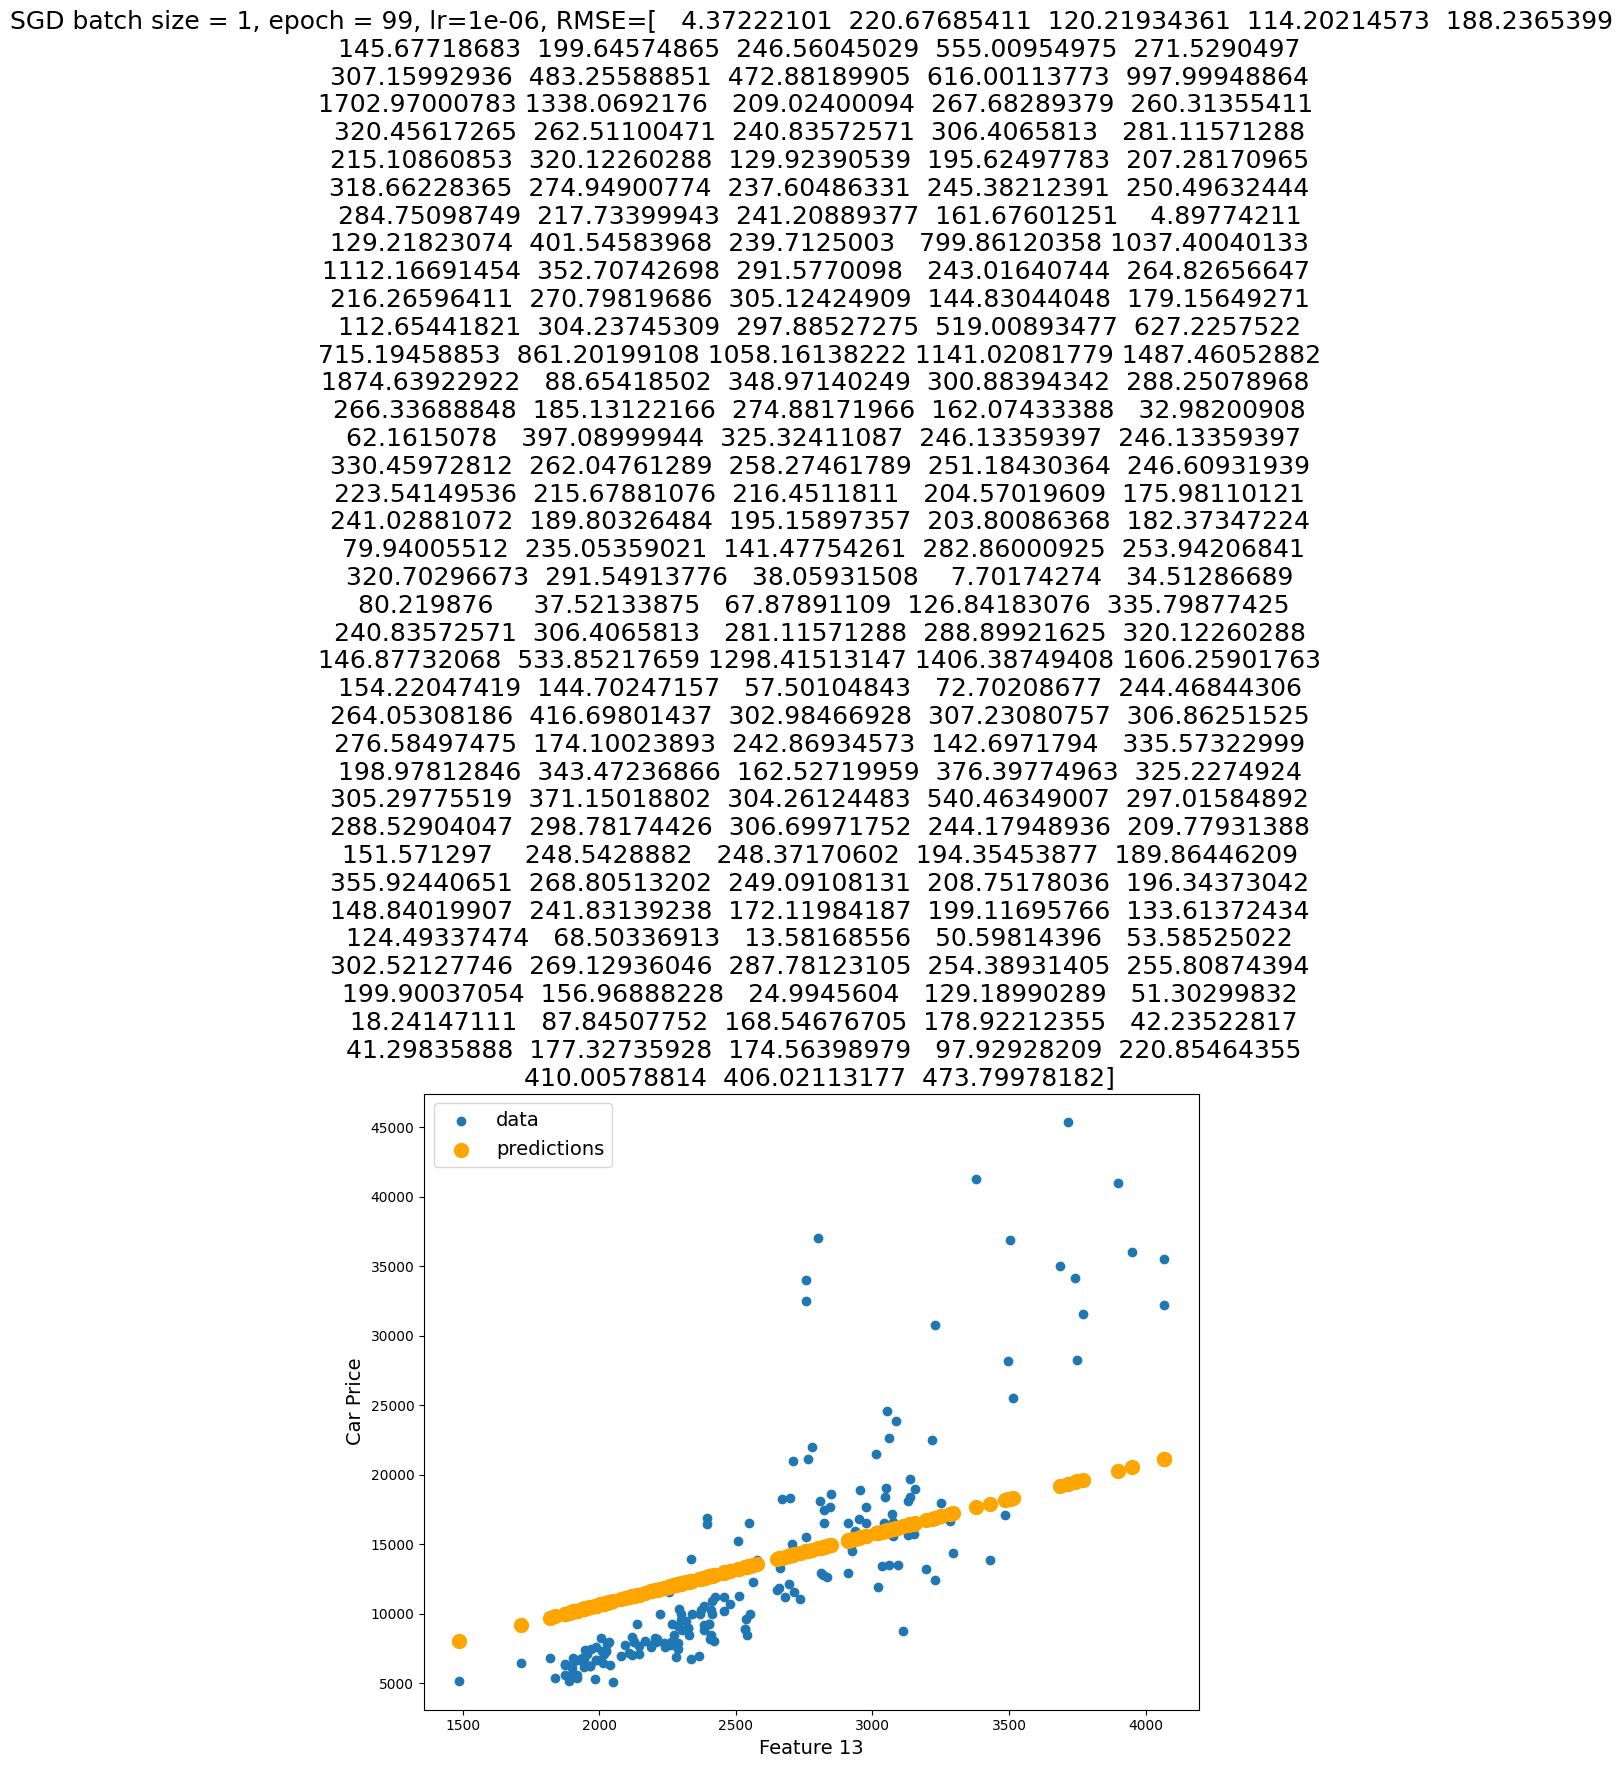

In [20]:
sgd.fit(Data[[13]],Data[25])

In [21]:
np.random.seed()

In [22]:
sgd.w

array([503.38766963,   5.07491032])

#3. (10pt) In this part you will use built-in functions for Linear Regression that are using SGD under the hood.

(1pt) Plot the histograms for numerical data and bar-plots for categorical features, add $x$ axis name (file Description.txt). You can get the names of the columns as follows:
```
# List of numerical columns (assuming they have numeric data types)
numerical_columns = Data.select_dtypes(exclude=['object']).columns.tolist()

# List of nominal (categorical) columns (assuming they have object data types)
nominal_columns = Data.select_dtypes(include=['object']).columns.tolist()

```
And then methods
```
Data[column].hist()
Data[column].value_counts().plot(kind='bar')
```

(1pt) Transform categorical data into numerical ([see SGD notebook](https://github.com/anton-selitskiy/RIT_ML/blob/main/SGD.ipynb)).

(3pt) Choose the features for prediction ([see Regression notebook](https://github.com/anton-selitskiy/RIT_ML/blob/main/ML8.ipynb))

(3pt) Choose the model by the greed-search (using validation set or cross-validation)

(2pt) Train the best model and report it's performance on the Test set. Justify your choice of the metric for evaluation.

In [23]:
# To have the names of the columns, we upload file Description.txt
description = pd.read_csv('https://raw.githubusercontent.com/anton-selitskiy/RIT_ML/main/2024_spring/Homeworks/Description.txt', delimiter=':', header=None)
Data.columns = description[0].str.strip() #delete extra spaces in the column names
Data.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,121.132075,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,121.132075,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,121.132075,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.000000,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.000000,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


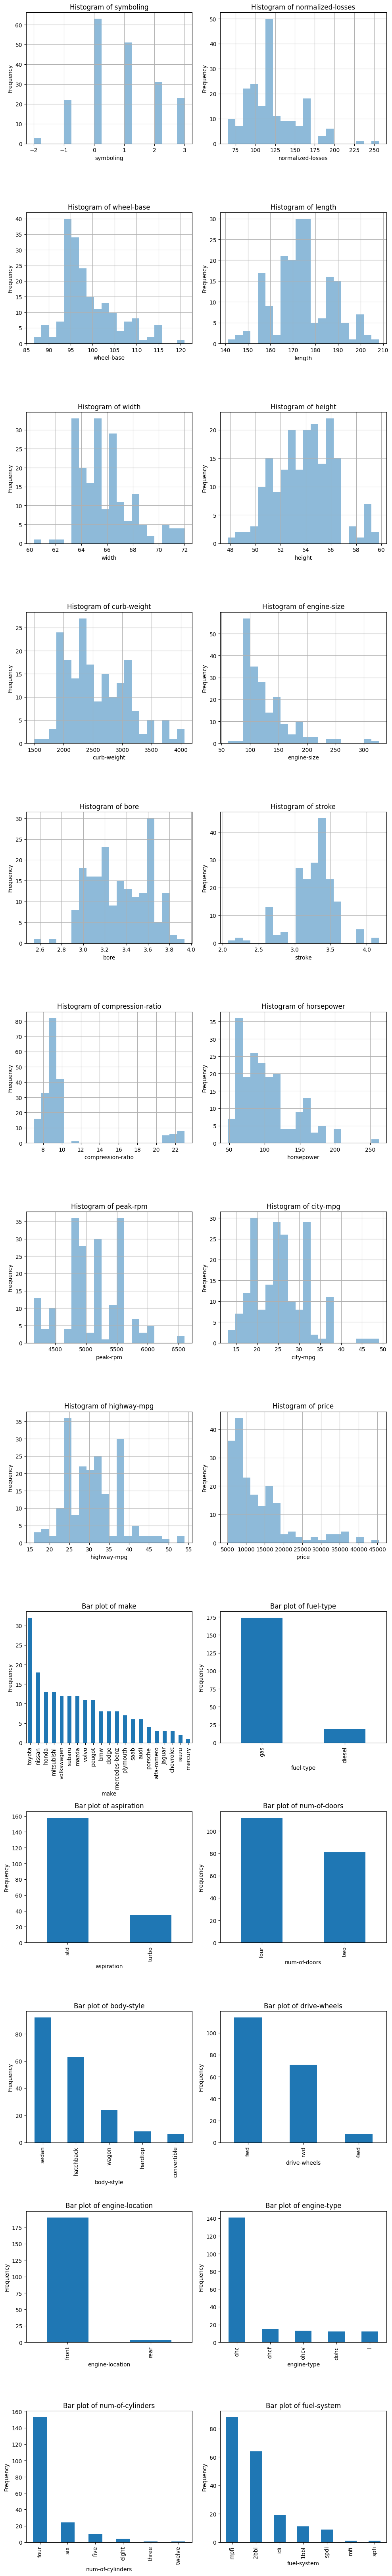

In [24]:
numerical_columns = Data.select_dtypes(exclude=['object']).columns.tolist()
nominal_columns = Data.select_dtypes(include=['object']).columns.tolist()

# Determine the number of rows and columns for subplots
num_numerical_plots = len(numerical_columns)
num_nominal_plots = len(nominal_columns)
total_plots = num_numerical_plots + num_nominal_plots
num_rows = total_plots // 2 + total_plots % 2
num_cols = 2

# Define the figure size based on the number of rows and columns
fig_width = 10
fig_height = 5 * num_rows

# Create a figure and axes objects for subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))

# Flatten the axes array if it's not already flat
axes = axes.flatten()

# Plot numerical columns
for i, column in enumerate(numerical_columns):
    Data[column].hist(ax=axes[i], alpha=0.5, bins=20)
    axes[i].set_xlabel(column)  # Set xlabel for the current column
    axes[i].set_ylabel('Frequency')  # Set ylabel
    axes[i].set_title(f'Histogram of {column}')  # Set title for the subplot

# Plot nominal columns
for j, column in enumerate(nominal_columns, start=i+1):
    Data[column].value_counts().plot(kind='bar', ax=axes[j])
    axes[j].set_xlabel(column)  # Set xlabel for the current column
    axes[j].set_ylabel('Frequency')  # Set ylabel
    axes[j].set_title(f'Bar plot of {column}')  # Set title for the subplot

# If the number of plots is odd, remove the last empty subplot
if total_plots % 2 != 0:
    fig.delaxes(axes[-1])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


[0.8122241  0.70472495] 0.7584745254577702


Text(0, 0.5, 'Score $R^2$')

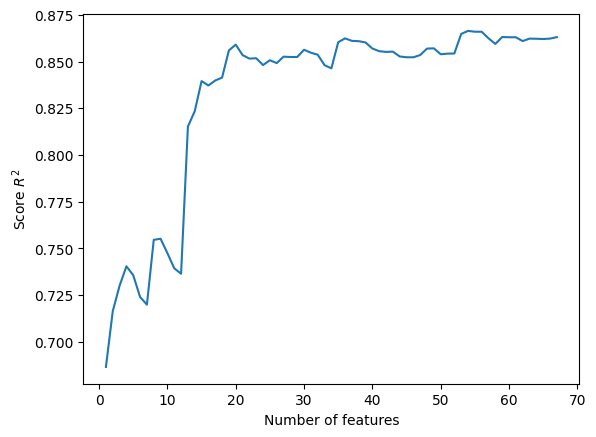

In [34]:
#Created data set
y = Data['price']
X = Data.drop(columns=['price'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#transform categorical into nominal
onee = OneHotEncoder()
transform = ColumnTransformer(transformers=[('one-hot', onee, ['make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 'drive-wheels', 'engine-location', 'engine-type', 'num-of-cylinders', 'fuel-system'])], remainder='passthrough')
transform.fit(X_train)

X_train_hot = pd.DataFrame(transform.transform(X_train), columns=transform.get_feature_names_out())
# X_train_hot.head()


from sklearn.model_selection import KFold
from sklearn.linear_model import SGDRegressor, Lasso, Ridge, ARDRegression, ElasticNet, HuberRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression, r_regression, f_regression
from sklearn.pipeline import Pipeline, make_pipeline

kf = KFold(n_splits=2) #might not need this
for train_index, test_index in kf.split(X_train_hot):
  X_train_cv = X_train_hot.iloc[train_index]
  y_train_cv = y_train.iloc[train_index]
  X_val_cv = X_train_hot.iloc[test_index]
  y_val_cv = y_train.iloc[test_index]


# for (train_index, test_index) in kf.split(X_train_hot):
#   print(train_index, test_index)

# best 9 features
pipe1 = Pipeline([('select', SelectKBest(r_regression, k=9)), ('sc', StandardScaler()), ('reg', Ridge())]) #l2 regularization is the ridge function
pipe1.fit(X_train_cv, y_train_cv)
pipe1.score(X_val_cv, y_val_cv)
pipe1[0].get_feature_names_out() #0.76

# all features (better but a lot of data)
pipe2 = Pipeline([('sc', StandardScaler()), ('reg', Ridge())])
pipe2.fit(X_train_cv, y_train_cv)
pipe2.score(X_val_cv, y_val_cv) #0.86



from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipe1, X_train_hot, y_train, cv=2) #KFold(2, shuffle=True)
print(scores, scores.mean())


# cross validation
corr_select = []
for r in range(1,X_train_hot.shape[1]):
  pipe1 = Pipeline([('sc', StandardScaler()), ('reg', Ridge())])
  corr_select.append(cross_val_score(pipe1, SelectKBest(r_regression, k=r).fit_transform(X_train_hot, y_train), y_train, cv=10).mean())

# analysis
plt.plot(list(range(1, X_train_hot.shape[1])), corr_select)
plt.xlabel('Number of features')
plt.ylabel('Score $R^2$')

In [ ]:
# Selecting better group of features using mutual inclusion
MI_select = []
for r in range(1, X_train_hot.shape[1]):
  pipe2 = Pipeline([('sc', StandardScaler()), ('reg', Ridge())])
  MI_select.append(cross_val_score(pipe2, SelectKBest(mutual_info_regression, k=r).fit_transform(X_train_hot, y_train), y_train, cv=10).mean())